In [1]:
%load_ext autoreload
%autoreload 2
import sys
import math

import matplotlib.pyplot as plt
import torch
from cirkit.templates import data_modalities, utils
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np

PIXEL_RANGE = 255
example_image = None

KERNEL_SIZE = (4, 4)
CIFAR_SIZE = (32,32)
DEVICE = "cuda:2"
EPOCH = 30


## Data Preparation

Let's define a function to create and use patches of the base Dataset

In [2]:
def patchify(kernel_size, stride, compile=True, contiguous_output=False):
    kh, kw = (kernel_size, kernel_size) if isinstance(kernel_size, int) else kernel_size
    sh, sw = (stride, stride) if isinstance(stride, int) else stride

    def _patchify(image: torch.Tensor):
        # Accept (C,H,W) or (B,C,H,W)

        # Ensure contiguous NCHW for predictable strides
        x = image.contiguous()  # (B,C,H,W)
        B, C, H, W = x.shape

        # Number of patches along H/W
        Lh = (H - kh) // sh + 1
        Lw = (W - kw) // sw + 1

        # Create a zero-copy view: (B, C, Lh, Lw, kh, kw)
        sN, sC, sH, sW = x.stride()
        patches = x.as_strided(
            size=(B, C, Lh, Lw, kh, kw),
            stride=(sN, sC, sH * sh, sW * sw, sH, sW),
        )
        # Reorder to (B, P, C, kh, kw) where P = Lh*Lw
        patches = patches.permute(0, 2, 3, 1, 4, 5).reshape(B * Lh * Lw, C, kh, kw)

        if contiguous_output:
            patches = (
                patches.contiguous()
            )  # materialize if the next ops need contiguous

        return patches

    if compile:
        _patchify = torch.compile(_patchify, fullgraph=True, dynamic=False)
    return _patchify


transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Lambda(lambda x: (PIXEL_RANGE * x).long()),
    ]
)

data_train = datasets.CIFAR10("datasets", train=True, download=True, transform=transform)
data_test = datasets.CIFAR10("datasets", train=False, download=True, transform=transform)

# Instantiate the training and testing data loaders
train_dataloader = DataLoader(data_train, shuffle=True, drop_last=True, batch_size=256)
test_dataloader = DataLoader(data_test, shuffle=False, batch_size=256)

## Defining the Circuit

We want to create a factory to create the different circuit we will want to compare.

In [3]:
def patch_circuit_factory(
    kernel_size, region_graph, layer_type, num_units, big_region_graph=None
):
    shared_circ = data_modalities.image_data(
        (3, *kernel_size),
        region_graph=region_graph,
        input_layer="categorical",
        num_input_units=num_units,
        sum_product_layer=layer_type,
        num_sum_units=num_units,
        num_classes=num_units,
        sum_weight_param=utils.Parameterization(
            activation="softmax", initialization="normal"
        ),
    )
    return shared_circ

def top_circuit_factory(
    subspace_size, region_graph, layer_type, num_units, big_region_graph=None
):
    shared_circ = data_modalities.image_data(
        (3, *subspace_size),
        region_graph=region_graph,
        input_layer="categorical",
        num_input_units=num_units,
        sum_product_layer=layer_type,
        num_sum_units=num_units,
        num_classes=1,
        sum_weight_param=utils.Parameterization(
            activation="softmax", initialization="normal"
        ),
    )
    return shared_circ

def base_circuit_factory(region_graph, layer_type, num_units):
    return data_modalities.image_data(
        (3, *CIFAR_SIZE),
        # (1,*kernel_size),
        region_graph=region_graph,
        input_layer="categorical",
        num_input_units=num_units,
        sum_product_layer=layer_type,
        num_sum_units=num_units,
        sum_weight_param=utils.Parameterization(
            activation="softmax", initialization="normal"
        ),
    )

In [4]:
%load_ext autoreload
%autoreload 2
from cirkit.backend.torch.layers.input import TorchCategoricalLayer
from cirkit.backend.torch.parameters.parameter import TorchParameter, TorchParameterNode, FoldIndexInfo
from cirkit.backend.torch.parameters.nodes import TorchParameterInput
from cirkit.backend.torch.graph.folding import build_unfold_index_info
from torch import Tensor
from cirkit.backend.torch.semiring import Semiring
from typing import Sequence, Mapping
import functools


def share_parameter(graph:TorchParameter, new_fold:int):
    new_param_nodes = []
    for i,n in enumerate(graph.topological_ordering()):
        instance = type(n)
        new_conf=n.config
        new_conf["num_folds"]=new_fold
        if "initializer_" in new_conf:
            reduced_initializer_list = new_conf["initializer_"].keywords["initializers"][:new_fold]
            new_conf["initializer_"]= functools.partial(new_conf["initializer_"].func, initializers=reduced_initializer_list)
        if "shape" in new_conf:
            shape=new_conf["shape"]
            del new_conf["shape"]
            new_param = instance(*shape, **new_conf)
        else:
            new_param = instance( **new_conf)
        new_param.reset_parameters()
        new_param_nodes.append(new_param)
   
    shared= TorchSharedParameter(graph.shape, new_param_nodes, num_folds=graph.num_folds)
    fold_idx_info = FoldIndexInfo(
        ordering=[shared],
        in_fold_idx={0:[[]]},
        out_fold_idx=[(0, f) for f in range(graph.num_folds)]
    )
    return TorchParameter([shared], {shared:[]}, [shared], fold_idx_info=fold_idx_info)


class PatchOrderingLayer:
    def __init__(self, size:tuple[int,int,int], patch:tuple[int,int]):
        self.patch_fn = patchify(patch, patch)
        self.size=size
        self.patch=patch
    
    def __call__(self,x:torch.Tensor):
        #x: (B,N) where N is W*H from the original image
        #We first retrieve the original image
        B,N = x.shape
        x=x.reshape(B,*self.size)
        patched = self.patch_fn(x)
        return patched.reshape(B,N)

# class TorchSharedParameter(TorchParameterInput):
#     def __init__(self,
#         in_shape:tuple[int,...],
#         parameter:list[torch.nn.Module],
#         num_folds:int
# ):class TorchSharedParameter(TorchParameterInput):
#     def __init__(self,
#         in_shape:tuple[int,...],
#         parameter:list[torch.nn.Module],
#         num_folds:int
# ):
#         super().__init__()
#         self._num_folds=num_folds
#         self.in_shape=in_shape
#         self.internal_param = torch.nn.ModuleList(parameter)
    
#     def forward(self):
#         current_input=None
#         for param in self.internal_param:
#             if current_input is None:
#                 current_input=param()
#             else:
#                 current_input=param(current_input)
#         share_fold, *inner_units = current_input.shape
#         return current_input.expand(self.num_folds//share_fold,share_fold, *inner_units).reshape(self.num_folds,*inner_units)

#     @property
#     def shape(self):
#         return self.in_shape
#         super().__init__()
#         self._num_folds=num_folds
#         self.in_shape=in_shape
#         self.internal_param = torch.nn.ModuleList(parameter)
    
#     def forward(self):
#         current_input=None
#         for param in self.internal_param:
#             if current_input is None:
#                 current_input=param()
#             else:
#                 current_input=param(current_input)
#         share_fold, *inner_units = current_input.shape
#         return current_input.expand(self.num_folds//share_fold,share_fold, *inner_units).reshape(self.num_folds,*inner_units)

#     @property
#     def shape(self):
#         return self.in_shape

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
from copy import copy
from cirkit.symbolic.circuit import Scope
from cirkit.symbolic.circuit import Circuit
import gc

from cirkit.symbolic.layers import InputLayer, SumLayer
from cirkit.symbolic.parameters import (
    Parameter,
)
from cirkit.backend.torch.parameters.parameter import TorchParameter
from cirkit.backend.torch.parameters.nodes import TorchParameterInput

from cirkit.backend.torch.layers.inner import TorchSumLayer
from cirkit.backend.torch.layers.optimized import TorchCPTLayer
from cirkit.backend.torch.layers.input import TorchInputLayer
from cirkit.backend.torch.circuits import TorchCircuit
from cirkit.backend.torch.parameters.nodes import TorchParameterInput, TorchMixingWeightParameter, TorchTensorParameter, TorchUnaryParameterOp
from cirkit.backend.torch.parameters.parameter import TorchParameter
from cirkit.backend.torch.layers.inner import TorchSumLayer
from cirkit.backend.torch.layers.optimized import TorchCPTLayer, TorchTuckerLayer
from cirkit.backend.torch.layers.input import TorchInputLayer
from cirkit.backend.torch.circuits import TorchCircuit

def patch_circuits(top_circuit_param, patch_circuit_param):
    im_shape = [i*k for i,k in zip(top_circuit_param["image_shape"],patch_circuit_param["image_shape"])]
    kernel_shape = patch_circuit_param["image_shape"]

    example_data = torch.arange(im_shape[0]*im_shape[1]*im_shape[2]).reshape(1, *im_shape)
    patch_fn = patchify(kernel_shape[1:], kernel_shape[1:])
    scope_order=patch_fn(example_data).reshape(-1, kernel_shape[0]*kernel_shape[1]*kernel_shape[2])
    print(scope_order)
    top = data_modalities.image_data(**top_circuit_param)
    new_layers = top._nodes.copy()
    new_inputs = top._in_nodes.copy()
    for new_scope,input_node in zip(scope_order, list(top.layerwise_topological_ordering())[0]):
        # Remove input node
        new_layers.remove(input_node)
        # add output of patch (create patch)
        patch = data_modalities.image_data(**patch_circuit_param)
        patch_input = list(patch.layerwise_topological_ordering())[0]
        for idx,inp in enumerate(patch_input):
            inp.scope= Scope([new_scope[list(inp.scope)[0]].item()])
        new_layers.extend(patch._nodes)

        # verify connections
        for node, inputs in top._in_nodes.items():
            if input_node in inputs:
                new_inputs[node].remove(input_node)
                new_inputs[node].extend(patch.outputs)
        new_inputs.update(patch._in_nodes)
        

        
    return Circuit(new_layers, new_inputs, top.outputs)


def copy_parameter(graph: TorchParameter, new_shape):
    new_param_nodes = []
    copy_map = {}
    in_nodes = {}
    outputs = []
    for n in graph.topological_ordering():
        instance = type(n)
        config = n.config
        if isinstance(n, TorchTensorParameter):
            del config["shape"]
            new_param = instance(*new_shape,**config)
            new_param._ptensor = torch.nn.Parameter(torch.zeros((graph.shape[0],*new_shape)))

        elif isinstance(n, TorchUnaryParameterOp):
            config["in_shape"]=new_shape

            new_param = instance(**config)
        new_param_nodes.append(new_param)
        copy_map[n] = new_param
        inputs = [copy_map[in_node] for in_node in graph.node_inputs(n)]
        if len(inputs) > 0:
            in_nodes[new_param] = inputs
    outputs = [copy_map[out_node] for out_node in graph.outputs]
    parameter= TorchParameter(modules=new_param_nodes, in_modules=in_nodes, outputs=outputs)
    return parameter

class TorchSharedParameter(TorchParameterInput):
    def __init__(self,
        in_shape:tuple[int,...],
        parameter:list[torch.nn.Module],
        num_folds:int
):
        super().__init__()
        self._num_folds=num_folds
        self.in_shape=in_shape
        self.internal_param = parameter
    
    def forward(self):
        current_input=None
        for param in self.internal_param:
            if current_input is None:
                current_input=param()
            else:
                current_input=param(current_input)
        share_fold, *inner_units = current_input.shape
        expanded = current_input.expand(self.num_folds//share_fold,share_fold, *inner_units).reshape(self.num_folds,*inner_units)

        return expanded

    @property
    def shape(self):
        return self.in_shape

def share_param_like(base_circ:TorchCircuit, share_struct:TorchCircuit, should_init_mean=False):
    for idx, layer in enumerate(share_struct.layers):
        print(layer)
        if isinstance(layer, TorchInputLayer):
            
            folds = base_circ.layers[idx].probs.num_folds
            shared_param = TorchSharedParameter(base_circ.layers[idx].probs.shape, parameter=layer.probs.nodes, num_folds=folds)
            base_circ.layers[idx].probs = shared_param
        elif isinstance(layer, TorchCPTLayer) or isinstance(layer, TorchSumLayer):
            internal_param=layer.weight.nodes
            if layer.num_output_units != base_circ.layers[idx].num_output_units:
                new_parameter = copy_parameter(layer.weight, base_circ.layers[idx].weight.nodes[0].shape)
                print(internal_param[0]._ptensor.data.shape)

                print(new_parameter.nodes[0]._ptensor.data.shape)
                _,o,i = internal_param[0]._ptensor.data.shape
                _, goal_o, goal_i = new_parameter.nodes[0]._ptensor.data.shape
                num_input = goal_i//i
                num_output = goal_o//o
                new_parameter.nodes[0]._ptensor.data=internal_param[0]._ptensor.data.clone().repeat((1, num_output, num_input))
                print(new_parameter.nodes[0]._ptensor.data.shape)

                internal_param=new_parameter.nodes
            folds = base_circ.layers[idx].weight.num_folds
            shared_param = TorchSharedParameter(base_circ.layers[idx].weight.shape, parameter=internal_param, num_folds=folds)
            base_circ.layers[idx].weight = shared_param
    if should_init_mean:
        init_mean(base_circ, len(share_struct.layers))


def init_mean(circ, start_idx):
    for layer in circ.layers[start_idx:]:
        print(layer)
        if isinstance(layer, TorchCPTLayer) or isinstance(layer, TorchSumLayer):
            param = layer.weight
            tensor = param.nodes[0]._ptensor
            inputs =tensor.shape[-1]

            param.nodes[0]._ptensor.data = torch.full(tensor.shape, torch.exp(torch.tensor(1/inputs)))


def freeze_parameter(param:TorchSharedParameter):
    for p in param.parameters():
        p.requires_grad = False

def rescope(base_circ, patch_circ, kernel_shape, im_shape):
    example_data = torch.arange(im_shape[0]*im_shape[1]*im_shape[2]).reshape(1, *im_shape)
    patch_fn = patchify(kernel_shape[1:], kernel_shape[1:])

    scope_order=patch_fn(example_data).reshape(-1,  kernel_shape[0]*kernel_shape[1]*kernel_shape[2])

    new_order=torch.empty_like(base_circ.layers[0].scope_idx)
    print(new_order.shape)
    for idx, patch_scope in enumerate(scope_order):
        start=idx*len(patch_scope)
        end=start+len(patch_scope)
        new_order[start:end]=patch_scope[patch_circ.layers[0].scope_idx]
    base_circ.layers[0]._scope_idx=new_order
    # return new_order

gc.collect()
torch.cuda.empty_cache()
patch_units=512
top_units=512
new_circ=patch_circuits(
    {
        "image_shape": (1, 8,8),
        "region_graph": "quad-graph",
        "input_layer": "categorical",
        "num_input_units": top_units,
        "sum_product_layer": "cp",
        "num_sum_units": top_units,
        "sum_weight_param": utils.Parameterization(
            activation="softmax", initialization="normal"
        ),
    },
     {
        "image_shape": (3,4,4),
        "region_graph": "quad-graph",
        "input_layer": "categorical",
        "num_input_units": patch_units,
        "sum_product_layer": "cp",
        "num_sum_units": patch_units,
        "num_classes":top_units,
        "sum_weight_param": utils.Parameterization(
            activation="softmax", initialization="normal"
        ),
    }
)



from cirkit.pipeline import compile

import sys
sys.path.append("pconv")

from src.benchmark_logic import BenchPCImage

trained_mod = BenchPCImage.load_from_checkpoint("pconv/checkpoints/epoch=99-step=29300.ckpt").cpu()
print(trained_mod.config)
patch_circ_trained = trained_mod.circuit

patch_circ=data_modalities.image_data(
        (3,4,4),
        region_graph="quad-graph",
        input_layer="categorical",
        num_input_units=patch_units,
        sum_product_layer="cp",
        num_sum_units=patch_units,
        num_classes=1,
        sum_weight_param=utils.Parameterization(
            activation="softmax", initialization="normal"
        ),
)
# input_circ=data_modalities.image_data(
#         (3,1,1),
#         region_graph="quad-graph",
#         input_layer="categorical",
#         num_input_units=patch_units,
#         sum_product_layer="cp-t",
#         num_sum_units=patch_units,
#         num_classes=patch_units,
#         sum_weight_param=utils.Parameterization(
#             activation="softmax", initialization="normal"
#         ),
# )
cpatch = compile(patch_circ)
cbase = compile(new_circ)
# cinput = compile(input_circ)

share_param_like(cbase, patch_circ_trained)
# rescope(cbase, patch_circ_trained, (3,4,4), (3,32,32))
# share_param_like(cbase, cinput)
# cbase

tensor([[   0,    1,    2,  ..., 2145, 2146, 2147],
        [   4,    5,    6,  ..., 2149, 2150, 2151],
        [   8,    9,   10,  ..., 2153, 2154, 2155],
        ...,
        [ 916,  917,  918,  ..., 3061, 3062, 3063],
        [ 920,  921,  922,  ..., 3065, 3066, 3067],
        [ 924,  925,  926,  ..., 3069, 3070, 3071]])
{'circuit_type': 'patch', 'layer_type': 'cp', 'region_graph': 'quad-graph', 'num_units': 512, 'lr': 0.05, 'dataset': 'cifar', 'kernel_size': [4, 4], 'batch_size': 128, 'experiment_path': 'experiments/bench-high-conf/', 'image_size': (32, 32), 'channel': 3}
TorchCategoricalLayer(
  folds: 48  variables: 1  output-units: 512
  input-shape: (48, 1, -1, 1)
  output-shape: (48, -1, 512)
  (probs): TorchParameter(
    shape: (48, 512, 256)
    (0): TorchTensorParameter(output-shape: (48, 512, 256))
    (1): TorchSoftmaxParameter(
      input-shapes: [(48, 512, 256)]
      output-shape: (48, 512, 256)
    )
  )
)
TorchHadamardLayer(
  folds: 16  arity: 3  input-units: 512 

In [36]:
pytorch_shared_params = sum(p.numel() for p in cbase.parameters() if p.requires_grad)
old_big_circ = compile(base_circuit_factory("quad-graph", "cp", 512))
pytorch_total_params = sum(p.numel() for p in old_big_circ.parameters() if p.requires_grad)
print(pytorch_total_params)
print(pytorch_shared_params)

1475695618
88631298


In [9]:
def test_circuit(circuit, patch=False):
    device = torch.device(DEVICE)
    circuit=circuit.to(device)
    patch_fn = patchify(KERNEL_SIZE, KERNEL_SIZE)

    with torch.no_grad():
        test_lls = 0.0

        for batch, _ in test_dataloader:
            # The circuit expects an input of shape (batch_dim, num_variables)
            if patch:
                batch = patch_fn(batch)
            BS = batch.shape[0]
            batch = batch.view(BS, -1).to(device)

            # Compute the log-likelihoods of the batch
            log_likelihoods = circuit(batch)

            # Accumulate the log-likelihoods
            test_lls += log_likelihoods.sum().item()

        # Compute average test log-likelihood and bits per dimension
        average_nll = -test_lls / len(data_test)
        bpd = average_nll / (32*32*3 * np.log(2.0))
        print(f"Average test LL: {average_nll:.3f}")
        print(f"Bits per dimension: {bpd:.3f}")

test_circuit(cbase)

Average test LL: 11710.888
Bits per dimension: 5.500


In [10]:
test_circuit(patch_circ_trained, patch=True)

Average test LL: 11710.888
Bits per dimension: 5.500


In [6]:
data = torch.randint(256, (1, 3,32,32))
cbase.cpu()
cbase(data.reshape(-1,3*32*32))

tensor([[[-24592.3906]]], grad_fn=<TransposeBackward0>)

In [7]:
patch_fn = patchify(4, 4)
patched = patch_fn(data).reshape(-1,3*4*4).cpu()
patch_circ_trained.cpu()
patch_circ_trained(patched).sum()

tensor(-24592.3906, grad_fn=<SumBackward0>)

In [17]:
cbase.layers[0].probs()

tensor([[[0.0116, 0.0033, 0.0048,  ..., 0.0011, 0.0020, 0.0005],
         [0.0008, 0.0010, 0.0009,  ..., 0.0009, 0.0039, 0.0018],
         [0.0026, 0.0023, 0.0004,  ..., 0.0013, 0.0220, 0.0153],
         ...,
         [0.0014, 0.0025, 0.0007,  ..., 0.0040, 0.0026, 0.0078],
         [0.0026, 0.0010, 0.0092,  ..., 0.0038, 0.0009, 0.0006],
         [0.0077, 0.0009, 0.0019,  ..., 0.0046, 0.0067, 0.0046]],

        [[0.0085, 0.0005, 0.0011,  ..., 0.0014, 0.0112, 0.0040],
         [0.0014, 0.0100, 0.0075,  ..., 0.0009, 0.0008, 0.0012],
         [0.0021, 0.0035, 0.0036,  ..., 0.0021, 0.0023, 0.0007],
         ...,
         [0.0022, 0.0016, 0.0045,  ..., 0.0031, 0.0019, 0.0026],
         [0.0008, 0.0011, 0.0004,  ..., 0.0065, 0.0008, 0.0048],
         [0.0028, 0.0061, 0.0012,  ..., 0.0036, 0.0093, 0.0034]],

        [[0.0029, 0.0058, 0.0018,  ..., 0.0011, 0.0011, 0.0004],
         [0.0016, 0.0026, 0.0188,  ..., 0.0018, 0.0071, 0.0017],
         [0.0203, 0.0027, 0.0011,  ..., 0.0067, 0.0008, 0.

In [18]:
cpatch.layers[0].probs()

tensor([[[0.0116, 0.0033, 0.0048,  ..., 0.0011, 0.0020, 0.0005],
         [0.0008, 0.0010, 0.0009,  ..., 0.0009, 0.0039, 0.0018],
         [0.0026, 0.0023, 0.0004,  ..., 0.0013, 0.0220, 0.0153],
         ...,
         [0.0014, 0.0025, 0.0007,  ..., 0.0040, 0.0026, 0.0078],
         [0.0026, 0.0010, 0.0092,  ..., 0.0038, 0.0009, 0.0006],
         [0.0077, 0.0009, 0.0019,  ..., 0.0046, 0.0067, 0.0046]],

        [[0.0085, 0.0005, 0.0011,  ..., 0.0014, 0.0112, 0.0040],
         [0.0014, 0.0100, 0.0075,  ..., 0.0009, 0.0008, 0.0012],
         [0.0021, 0.0035, 0.0036,  ..., 0.0021, 0.0023, 0.0007],
         ...,
         [0.0022, 0.0016, 0.0045,  ..., 0.0031, 0.0019, 0.0026],
         [0.0008, 0.0011, 0.0004,  ..., 0.0065, 0.0008, 0.0048],
         [0.0028, 0.0061, 0.0012,  ..., 0.0036, 0.0093, 0.0034]],

        [[0.0029, 0.0058, 0.0018,  ..., 0.0011, 0.0011, 0.0004],
         [0.0016, 0.0026, 0.0188,  ..., 0.0018, 0.0071, 0.0017],
         [0.0203, 0.0027, 0.0011,  ..., 0.0067, 0.0008, 0.

In [12]:
cbase.layers[0].scope_idx[0:16]

tensor([[   0],
        [1024],
        [2048],
        [   1],
        [1025],
        [2049],
        [   2],
        [1026],
        [2050],
        [   3],
        [2051],
        [1027],
        [  32],
        [1056],
        [2080],
        [  33]])

In [15]:
patch_circ_trained.layers[3].weight()

tensor([[[2.1613e-09, 2.1431e-09, 3.6560e-09,  ..., 7.4792e-03,
          5.0671e-08, 1.7350e-09],
         [9.4486e-04, 7.6018e-09, 5.8930e-09,  ..., 2.0203e-03,
          1.2374e-08, 1.0862e-08],
         [2.6816e-09, 2.2701e-09, 3.5041e-09,  ..., 1.9916e-09,
          2.4507e-09, 4.0534e-09],
         ...,
         [2.7938e-08, 6.6198e-08, 3.4376e-08,  ..., 1.7326e-08,
          2.0657e-08, 1.3561e-07],
         [5.4650e-09, 7.2708e-09, 7.1364e-09,  ..., 4.1515e-09,
          5.6903e-09, 5.8939e-08],
         [2.1024e-06, 1.4420e-06, 1.3987e-06,  ..., 2.0222e-07,
          1.9726e-06, 1.8803e-06]],

        [[8.9590e-07, 1.0745e-06, 7.6588e-07,  ..., 1.3676e-06,
          2.2715e-06, 7.6267e-07],
         [2.7846e-03, 4.7248e-09, 5.1307e-09,  ..., 5.1690e-09,
          5.1418e-09, 7.1918e-09],
         [2.2786e-08, 3.9076e-08, 1.0242e-07,  ..., 4.8132e-08,
          4.9310e-08, 4.1642e-08],
         ...,
         [5.0377e-09, 4.8060e-09, 4.1626e-09,  ..., 4.4811e-06,
          9.801

## Training

In [ ]:
import os

os.environ["CUDA_LAUNCH_BLOCKING"] = "0"

In [13]:
import random
import time

import numpy as np
import pandas as pd
from cirkit.pipeline import compile
import gc 

gc.collect()
torch.cuda.empty_cache()

def train_and_eval_circuit(circuit, patch: bool):
    # Set some seeds
    random.seed(42)
    np.random.seed(42)
    torch.manual_seed(42)
    # torch.cuda.manual_seed(42)

    # Set the torch device to use
    device = torch.device(DEVICE)
    # device="cpu"
    # Move the circuit to chosen device
    circuit = circuit.to(device)

    num_epochs = 10
    step_idx = 0
    running_loss = 0.0
    running_samples = 0
    stats = dict()

    stats["# trainable parameters"] = sum(
        p.numel() for p in circuit.parameters() if p.requires_grad
    )
    stats["train loss"] = []
    patch_order=PatchOrderingLayer((1,*CIFAR_SIZE), KERNEL_SIZE)
    # Initialize a torch optimizer of your choice,
    #  e.g., Adam, by passing the parameters of the circuit
    optimizer = torch.optim.Adam(circuit.parameters(), lr=0.05)
    begin_train = time.time()
    for epoch_idx in range(num_epochs):
        for i, (batch, _) in enumerate(train_dataloader):
            # The circuit expects an input of shape (batch_dim, num_variables)
            BS = batch.shape[0]
            batch=batch.view(BS, -1)
            if patch:
                batch = patch_order(batch)
            batch = batch.to(device)
            # Compute the log-likelihoods of the batch, by evaluating the circuit
            log_likelihoods = circuit(batch)

            # We take the negated average log-likelihood as loss
            loss = -torch.mean(log_likelihoods)
            loss.backward()
            # Update the parameters of the circuits, as any other model in PyTorch
            optimizer.step()
            optimizer.zero_grad()
            running_loss += loss.detach() * len(batch)
            running_samples += len(batch)
            step_idx += 1
            if step_idx % 200 == 0:
                average_nll = running_loss / running_samples
                print(f"Step {step_idx}: Average NLL: {average_nll:.3f}")
                running_loss = 0.0
                running_samples = 0

                stats["train loss"].append(average_nll.cpu().item())
    end_train = time.time()

    with torch.no_grad():
        test_lls = 0.0

        for batch, _ in test_dataloader:
            # The circuit expects an input of shape (batch_dim, num_variables)
            BS = batch.shape[0]
            batch=batch.view(BS, -1)
            if patch:
                batch = patch_order(batch)
            batch = batch.to(device)

            # Compute the log-likelihoods of the batch
            print(batch.shape)
            log_likelihoods = circuit(batch)
            print(log_likelihoods.shape)

            # Accumulate the log-likelihoods
            test_lls += log_likelihoods.sum().item()

        # Compute average test log-likelihood and bits per dimension
        average_nll = -test_lls / len(data_test)
        bpd = average_nll / (32*32*3 * np.log(2.0))
        print(f"Average test LL: {average_nll:.3f}")
        print(f"Bits per dimension: {bpd:.3f}")

        stats["test loss"] = average_nll
        stats["test bits per dimension"] = bpd
    end_test = time.time()

    # Free GPU memory
    circuit = circuit.to("cpu")
    torch.cuda.empty_cache()

    stats["train loss (min)"] = min(stats["train loss"])
    stats["train time"] = end_train - begin_train
    stats["test time"] = end_test - end_train

    return stats


# results = dict()
# for k, cc in circuits.items():
#     print('\nTraining circuit "%s"' % k)
#     ctype = k.split("+")[0].strip()
#     results[k] = train_and_eval_circuit(cc, patch=False)
#     results[k]["type"] = k.spli512t("+")[0].strip()
#     results[k]["sum product layer"] = k.split("+")[1].strip()
#     results[k]["structure"] = k.split("+")[2].strip()
# base_circ = cirkit_compile(stitched)
# base_circ.reset_parameters()
train_and_eval_circuit(cbase, False)

Step 200: Average NLL: 11506.787
Step 400: Average NLL: 11498.851
Step 600: Average NLL: 11493.236
Step 800: Average NLL: 11490.054
Step 1000: Average NLL: 11482.754
Step 1200: Average NLL: 11486.951
Step 1400: Average NLL: 11485.080
Step 1600: Average NLL: 11480.399
Step 1800: Average NLL: 11479.311
torch.Size([256, 3072])
torch.Size([256, 1, 1])
torch.Size([256, 3072])
torch.Size([256, 1, 1])
torch.Size([256, 3072])
torch.Size([256, 1, 1])
torch.Size([256, 3072])
torch.Size([256, 1, 1])
torch.Size([256, 3072])
torch.Size([256, 1, 1])
torch.Size([256, 3072])
torch.Size([256, 1, 1])
torch.Size([256, 3072])
torch.Size([256, 1, 1])
torch.Size([256, 3072])
torch.Size([256, 1, 1])
torch.Size([256, 3072])
torch.Size([256, 1, 1])
torch.Size([256, 3072])
torch.Size([256, 1, 1])
torch.Size([256, 3072])
torch.Size([256, 1, 1])
torch.Size([256, 3072])
torch.Size([256, 1, 1])
torch.Size([256, 3072])
torch.Size([256, 1, 1])
torch.Size([256, 3072])
torch.Size([256, 1, 1])
torch.Size([256, 3072])
to

{'# trainable parameters': 88631298,
 'train loss': [11506.787109375,
  11498.8505859375,
  11493.236328125,
  11490.0537109375,
  11482.75390625,
  11486.951171875,
  11485.080078125,
  11480.3994140625,
  11479.310546875],
 'test loss': 11538.91751875,
 'test bits per dimension': np.float64(5.418990586434703),
 'train loss (min)': 11479.310546875,
 'train time': 608.2784242630005,
 'test time': 5.901854515075684}

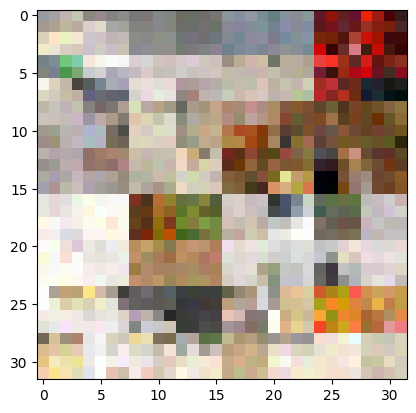

In [15]:
from cirkit.backend.torch.queries import SamplingQuery
from src.utils import unpatchify

unpatch_fn = unpatchify(CIFAR_SIZE, KERNEL_SIZE, KERNEL_SIZE,1)
circuit = cbase.cpu()
query = SamplingQuery(circuit)

samples, _ = query(num_samples=1)
# samples = unpatch_fn(samples).reshape(28,28,1)
plt.imshow(samples.reshape(3,32,32).permute(1,2,0), cmap="grey")